In [75]:
# Импортируем все необходимые библиотеки и функции

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical, plot_model

In [76]:
# Из готового датасета формируем массив NumPy, где:
# X - бинарное представление изображений
# Y - лейблы 

X = np.zeros((69000, 29*22))
Y = np.zeros((69000,))

loaded = np.load("XY.npz")
X = loaded['x']
Y = loaded['y']

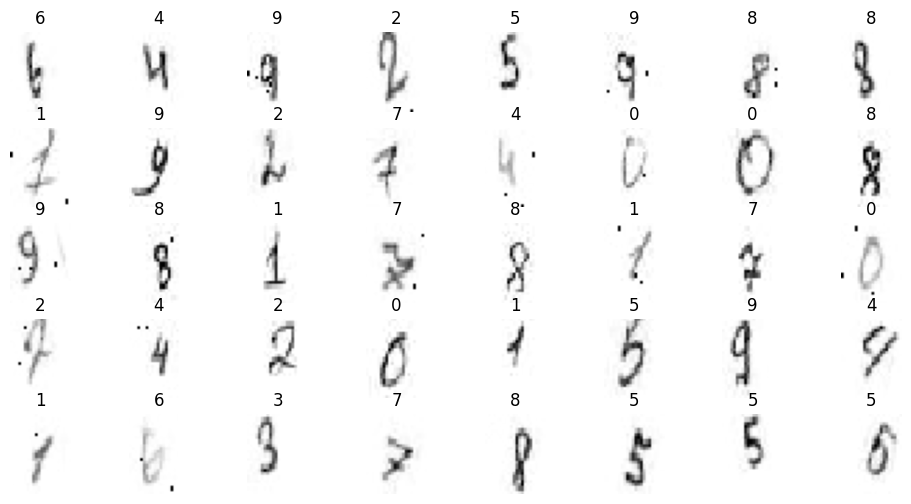

In [77]:
# Разделяем датасет на обучающую и тренировочную выборки
# Проверяем правильность разделения

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
fig, axes = plt.subplots(5, 8, figsize=(12, 6))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_train[i].reshape((29, 22)), cmap="gray")
    ax.set_title(str(int(Y_train[i])))
    ax.axis('off')

plt.show()

In [78]:
# Производим one-hot encoding

Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

In [79]:
# Общая идея модели заключается в использовании сверточных слоев (Conv2D) для извлечения 
# признаков из входных данных, а затем последующей классификации с помощью полносвязных слоев (Dense). 
# Dropout слои (Dropout) помогают уменьшить переобучение, отключая случайные нейроны во время обучения.

# основная CNN модель
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(29, 22, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(Y_train.shape[1], activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 27, 20, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 8, 64)         18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 512)              

In [80]:
# упрощенная CNN модель
# В этой упрощенной модели мы удалили один сверточный слой, уменьшили количество фильтров в 
# оставшемся сверточном слое до 16 и удалили несколько полносвязных слоев. Это приведет к ухудшению 
# способности модели различать изображения по сравнению с исходной моделью, но она все равно должна 
# быть способна выполнять задачу классификации изображений.
model_reduced = Sequential()
model_reduced.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(29, 22, 1)))
model_reduced.add(MaxPooling2D(pool_size=(2, 2)))
model_reduced.add(Flatten())
model_reduced.add(Dense(128, activation='relu'))
model_reduced.add(Dropout(0.4))
model_reduced.add(Dense(Y_train.shape[1], activation='softmax'))

model_reduced.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 27, 20, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 2080)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               266368    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 10)                1290      
                                                      

In [81]:
# Определяем количество эпох для обучения
epoch_num = 20

# Компилируем основную CNN модель
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=[
                'accuracy', 
                'mean_absolute_percentage_error', 
                'mean_absolute_error', 
                'mean_squared_error'
                ])

In [ ]:
# Компилируем вторую, упрощённую CNN модель
model_reduced.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=[
                'accuracy', 
                'mean_absolute_percentage_error', 
                'mean_absolute_error', 
                'mean_squared_error'
                ])

In [82]:
# нормализуем данные
X_train = X_train.reshape(X_train.shape[0], 29, 22, 1)
X_test = X_test.reshape(X_test.shape[0], 29, 22, 1)
X_train.shape

(55200, 29, 22, 1)

In [83]:
# Собираем необходимые метрики и обучаем CNN модель

train_acc = []
train_mape = []
train_mae = []
train_mse = []
test_acc = []

history = model.fit(X_train, Y_train, epochs=epoch_num, batch_size=batch_size)

train_acc.extend(history.history['accuracy'])
train_mape.extend(history.history['mean_absolute_percentage_error'])
train_mae.extend(history.history['mean_absolute_error'])
train_mse.extend(history.history['mean_squared_error'])
loss = history.history['loss']

Epoch 1/20
432/432 [==============================] - 11s 24ms/step - loss: 1.2600 - accuracy: 0.5428 - mean_absolute_percentage_error: 55690964.0000 - mean_absolute_error: 0.1114 - mean_squared_error: 0.0545
Epoch 2/20
432/432 [==============================] - 10s 24ms/step - loss: 0.3056 - accuracy: 0.9045 - mean_absolute_percentage_error: 15375032.0000 - mean_absolute_error: 0.0308 - mean_squared_error: 0.0144
Epoch 3/20
432/432 [==============================] - 11s 26ms/step - loss: 0.1697 - accuracy: 0.9475 - mean_absolute_percentage_error: 8575752.0000 - mean_absolute_error: 0.0172 - mean_squared_error: 0.0081
Epoch 4/20
432/432 [==============================] - 12s 28ms/step - loss: 0.1207 - accuracy: 0.9622 - mean_absolute_percentage_error: 6055222.0000 - mean_absolute_error: 0.0121 - mean_squared_error: 0.0058
Epoch 5/20
432/432 [==============================] - 12s 28ms/step - loss: 0.1000 - accuracy: 0.9693 - mean_absolute_percentage_error: 4951265.5000 - mean_absolute_e

In [86]:
model.save("CNN-1.keras")
evaluation = model.evaluate(X_test, Y_test, batch_size=batch_size)

108/108 [==============================] - 1s 7ms/step - loss: 0.0251 - accuracy: 0.9922 - mean_absolute_percentage_error: 992753.0625 - mean_absolute_error: 0.0020 - mean_squared_error: 0.0012


In [85]:
# Собираем необходимые метрики и обучаем MSP модель

train_acc = []
train_mape = []
train_mae = []
train_mse = []
test_acc = []

history_reduced = model_reduced.fit(X_train, Y_train, epochs=epoch_num, batch_size=batch_size)

train_acc.extend(history_reduced.history['accuracy'])
train_mape.extend(history_reduced.history['mean_absolute_percentage_error'])
train_mae.extend(history_reduced.history['mean_absolute_error'])
train_mse.extend(history_reduced.history['mean_squared_error'])
loss = history_reduced.history['loss']

Epoch 1/20
432/432 [==============================] - 4s 9ms/step - loss: 2.0023 - accuracy: 0.2506 - mean_absolute_percentage_error: 83886784.0000 - mean_absolute_error: 0.1678 - mean_squared_error: 0.0828
Epoch 2/20
432/432 [==============================] - 4s 10ms/step - loss: 1.7297 - accuracy: 0.3551 - mean_absolute_percentage_error: 76611488.0000 - mean_absolute_error: 0.1532 - mean_squared_error: 0.0749
Epoch 3/20
432/432 [==============================] - 4s 10ms/step - loss: 1.5425 - accuracy: 0.4368 - mean_absolute_percentage_error: 70469552.0000 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0683
Epoch 4/20
432/432 [==============================] - 4s 10ms/step - loss: 1.3965 - accuracy: 0.4944 - mean_absolute_percentage_error: 65403424.0000 - mean_absolute_error: 0.1308 - mean_squared_error: 0.0630
Epoch 5/20
432/432 [==============================] - 4s 10ms/step - loss: 1.1996 - accuracy: 0.5764 - mean_absolute_percentage_error: 57993452.0000 - mean_absolute_erro

In [88]:
model_reduced.save("CNN-2.keras")
evaluation = model_reduced.evaluate(X_test, Y_test, batch_size=batch_size)

108/108 [==============================] - 0s 3ms/step - loss: 0.2540 - accuracy: 0.9236 - mean_absolute_percentage_error: 13890780.0000 - mean_absolute_error: 0.0278 - mean_squared_error: 0.0118


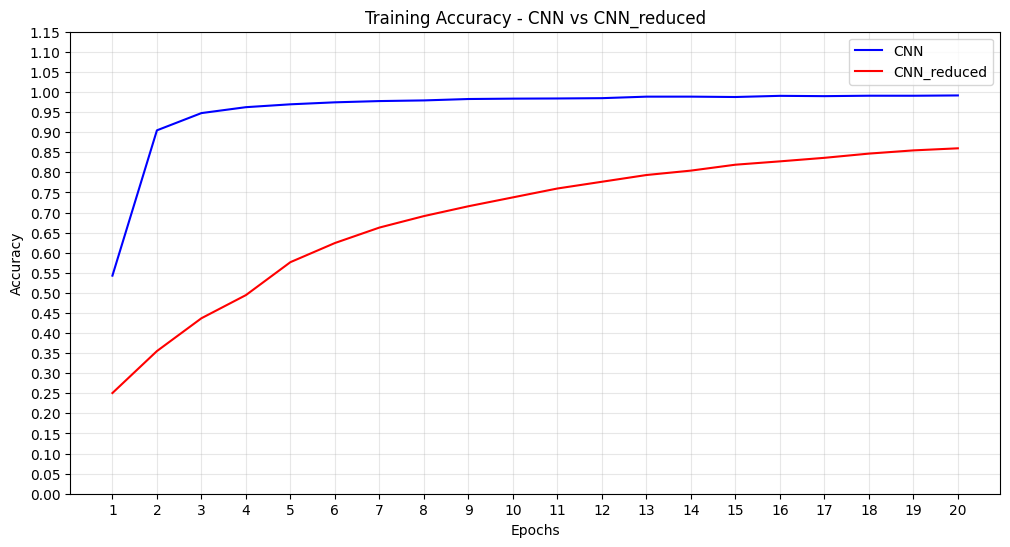

In [107]:
# График точности на обучающей- количества правильных предсказаний, поделенное на общее количество примеров.

epochs = range(1, 21)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['accuracy'], 'b', label='CNN')
plt.plot(epochs, history_reduced.history['accuracy'], 'r', label='CNN_reduced')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 1.2, 0.05))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.title('Training Accuracy - CNN vs CNN_reduced')
plt.legend()
plt.show()

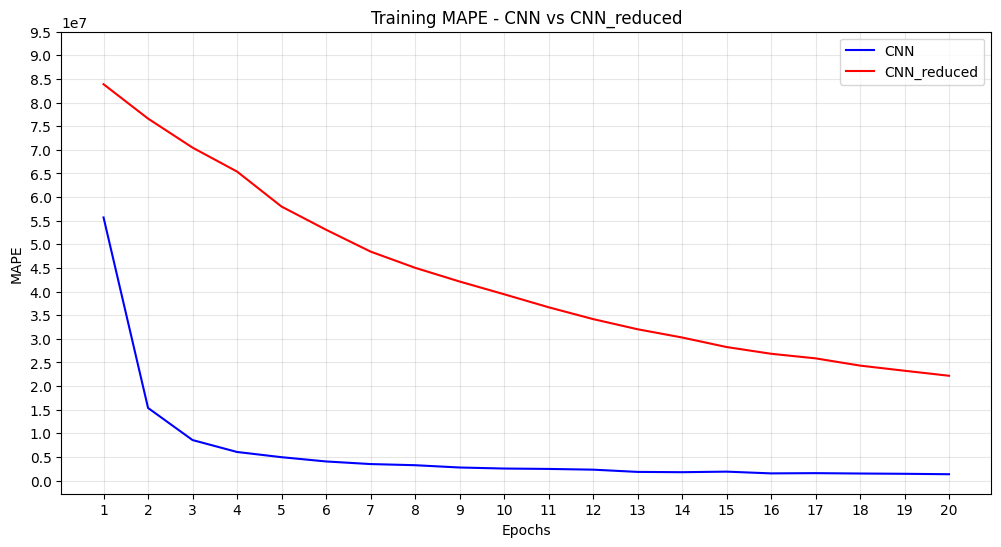

In [111]:
# График MAPE - Keras вычисляет абсолютное значение процентной разницы между предсказанными и 
# истинными значениями для каждого примера, а затем вычисляет среднее значение всех таких разниц.

epochs = range(1, 21)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['mean_absolute_percentage_error'], 'b', label='CNN')
plt.plot(epochs, history_reduced.history['mean_absolute_percentage_error'], 'r', label='CNN_reduced')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 100000000, 5000000))
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.grid(alpha=0.3)
plt.title('Training MAPE - CNN vs CNN_reduced')
plt.legend()
plt.show()

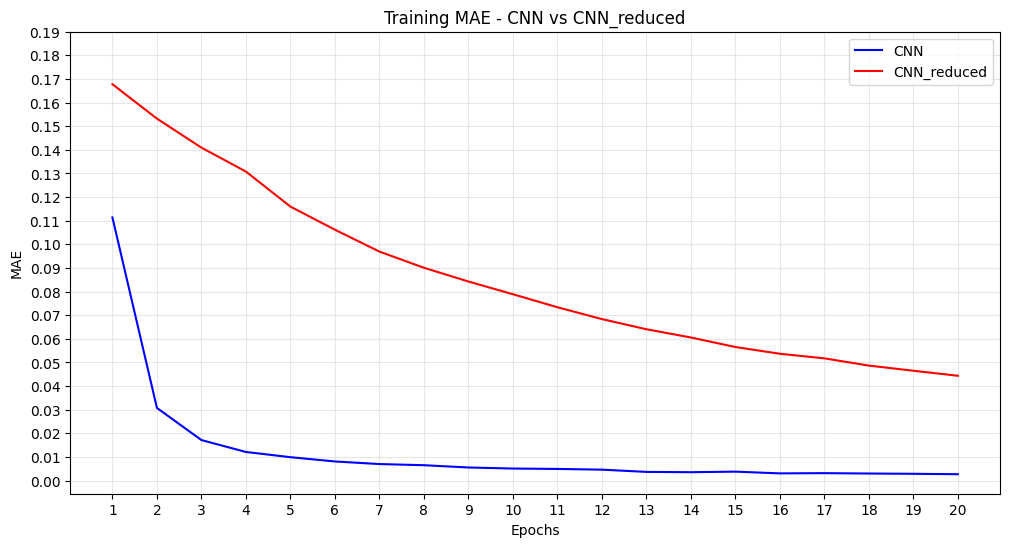

In [118]:
# График MAE - Keras вычисляет абсолютное значение разницы между предсказанными и 
# истинными значениями для каждого примера, а затем вычисляет среднее значение всех таких разниц.

epochs = range(1, 21)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['mean_absolute_error'], 'b', label='CNN')
plt.plot(epochs, history_reduced.history['mean_absolute_error'], 'r', label='CNN_reduced')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 0.2, 0.01))
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(alpha=0.3)
plt.title('Training MAE - CNN vs CNN_reduced')
plt.legend()
plt.show()

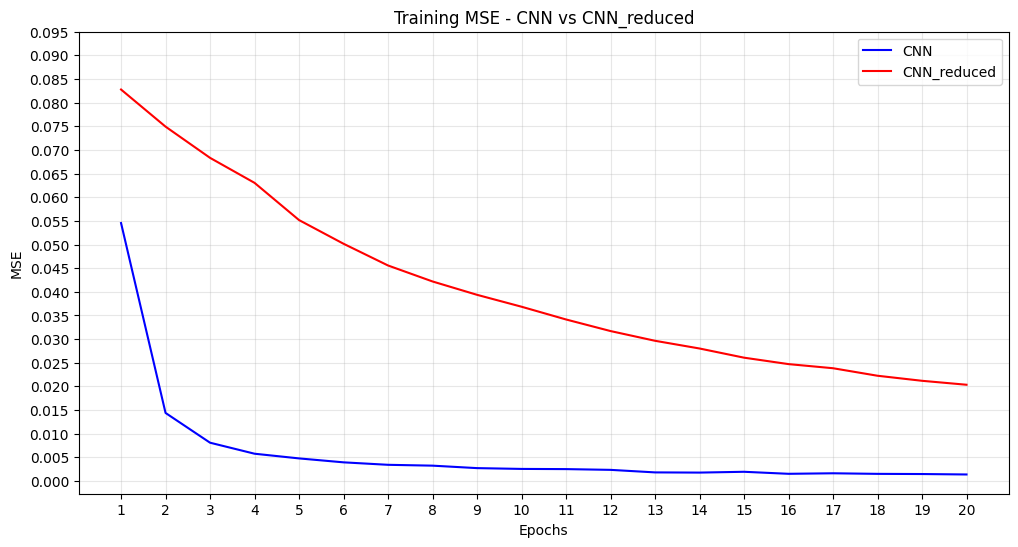

In [119]:
# График MSE - Keras вычисляет квадрат разницы между предсказанными и 
# истинными значениями для каждого примера, а затем вычисляет среднее значение всех таких квадратов.

epochs = range(1, 21)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['mean_squared_error'], 'b', label='CNN')
plt.plot(epochs, history_reduced.history['mean_squared_error'], 'r', label='CNN_reduced')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
plt.yticks(np.arange(0, 0.1, 0.005))
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(alpha=0.3)
plt.title('Training MSE - CNN vs CNN_reduced')
plt.legend()
plt.show()

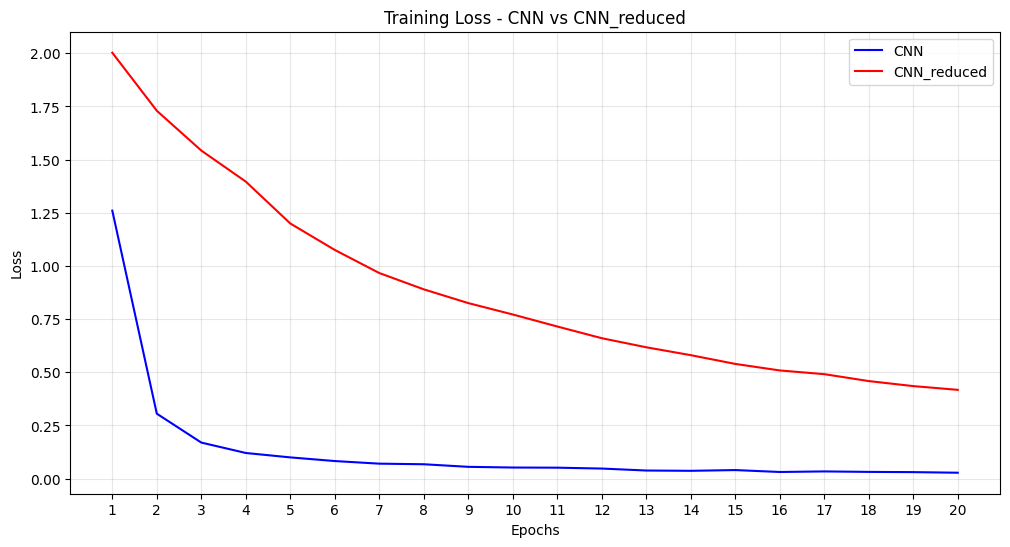

In [120]:
# График Loss - числовой оценки, показывающей, насколько близки или далеки 
# предсказания модели от истинных значений целевой переменной.

epochs = range(1, 21)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'b', label='CNN')
plt.plot(epochs, history_reduced.history['loss'], 'r', label='CNN_reduced')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 1))
# plt.yticks(np.arange(0, 100000000, 5000000))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.title('Training Loss - CNN vs CNN_reduced')
plt.legend()
plt.show()

In [124]:
# Импорт библиотек для теста

from tensorflow import keras
from keras.utils import load_img, img_to_array
import numpy as np
import os, random
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

In [125]:
# Загружаем модели

subfolders = [f.path for f in os.scandir("crop/") if f.is_dir()]
rdict = {}

model = keras.models.load_model("CNN-1.keras")
model_reduced = keras.models.load_model("CNN-2.keras")

In [126]:
# Случайно выбираем картинки и их лейблы из всего датасета

for subf in subfolders:
    for i in range(2):
        choice = random.choice(os.listdir(subf))
        img = load_img(f"{subf}/{choice}", target_size=(29, 22), color_mode="grayscale")
        img_arr = (img_to_array(img) / 255.0).reshape(-1)
        img_arr = img_arr.reshape(1, 29, 22, 1)
        rdict[choice] = img_arr

1/1 [==============================] - 0s 17ms/step


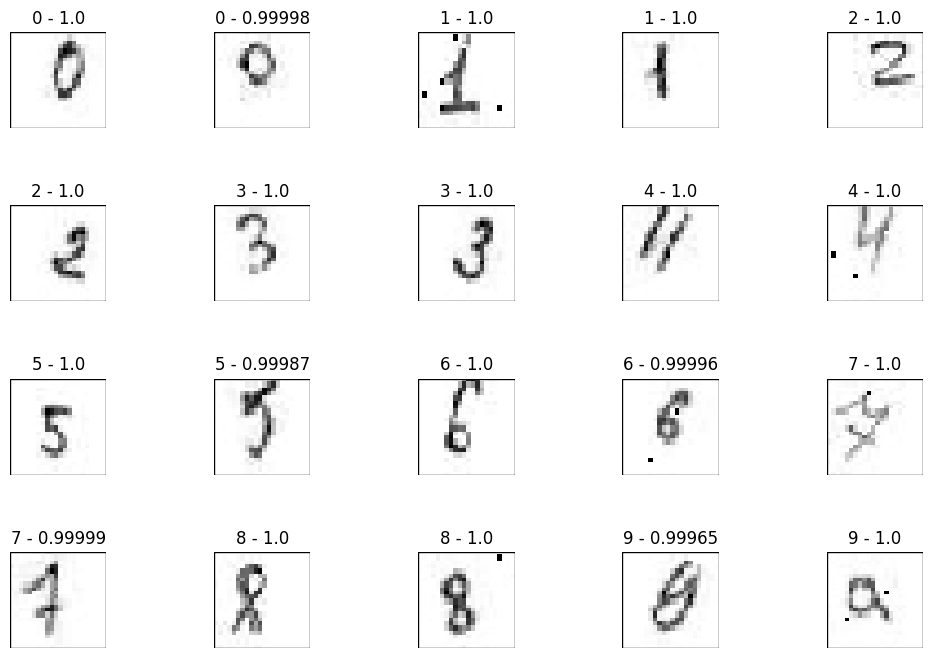

In [135]:
# Проверяем основную CNN модель
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

for i, (key, value) in enumerate(rdict.items()):
    prediction = model.predict(value)
    prediction = prediction.tolist()[0]
    prediction = [f"{j} - " + str(round(i, 5)) for j, i in enumerate(prediction) if i > 0.001]

    max_index = np.argmax(prediction)
    
    img = load_img(f"crop/{key[0]}/{key}", target_size=(29, 22), color_mode="grayscale")
    ax = axs[i//5, i%5]
    ax.imshow(img, cmap="gray", extent=[0, 1, 0, 1])
    ax.axis("off")
    ax.set_title("\n".join(prediction), fontsize=12)
    rect = Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

1/1 [==============================] - 0s 14ms/step


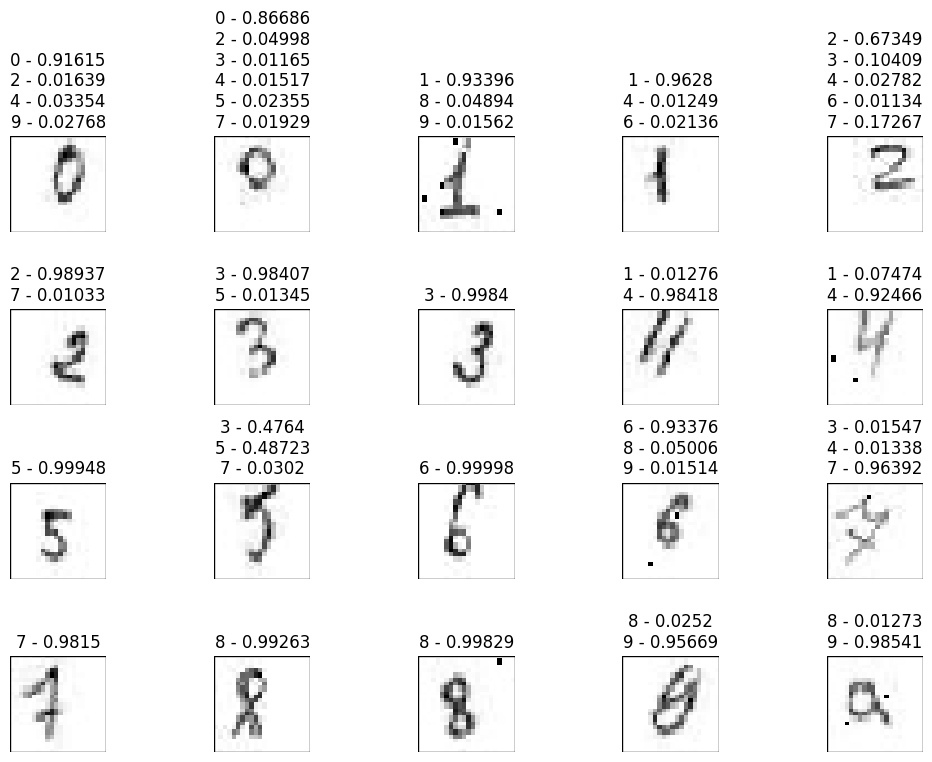

In [138]:
# Проверяем упрощённую CNN модель
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

for i, (key, value) in enumerate(rdict.items()):
    prediction = model_reduced.predict(value)
    prediction = prediction.tolist()[0]
    prediction = [f"{j} - " + str(round(i, 5)) for j, i in enumerate(prediction) if i > 0.01]

    max_index = np.argmax(prediction)
    
    img = load_img(f"crop/{key[0]}/{key}", target_size=(29, 22), color_mode="grayscale")
    ax = axs[i//5, i%5]
    ax.imshow(img, cmap="gray", extent=[0, 1, 0, 1])
    ax.axis("off")
    ax.set_title("\n".join(prediction), fontsize=12)
    rect = Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()